Importing libraries

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import time
import json

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Reading the files into training and validation datasets with a 80%-20% split

In [3]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Augmented Dorsal Vein/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

Found 5516 files belonging to 138 classes.
Using 4413 files for training.
Using 1103 files for validation.


In [4]:
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)

In [5]:
def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"Total number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Total number of samples in train_dataset: 3520 (110 batches of 32)
Total number of samples in validation_dataset: 1120 (35 batches of 32)
Total number of samples in test_dataset: 864 (27 batches of 32)


Prefetching data into GPU memory to optimize training process

In [6]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

Visualizing some training images

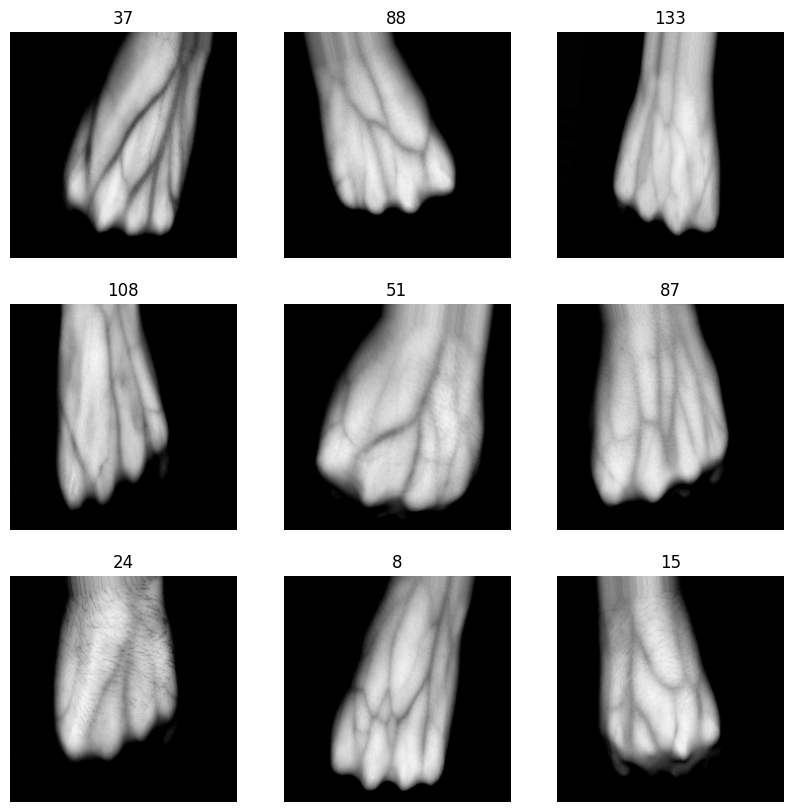

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Define some key constants

In [8]:
num_classes = 138
image_size = (224, 224, 3)

Defining function to return AlexNet Model with reduced number of filters as per research paper

In [9]:
def make_alexnet_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Layer 1: Convolutional + Max Pooling
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), strides=(4, 4), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 2: Convolutional + Max Pooling
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)
    x = layers.BatchNormalization()(x)

    # Layer 3: Three Convolutional Layers
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Max Pooling
    x = layers.MaxPooling2D((3, 3), strides=(2,2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return keras.Model(inputs, outputs)


Defining function to return VGG16 Model with reduced number of filters as per research paper

In [10]:
def make_vgg16_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

Defining function to return VGG19 Model with reduced number of filters as per research paper

In [11]:
def make_vgg19_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Block 1
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 2
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)


    # Block 3
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 4
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Block 5
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)


Training each model

In [12]:
from tqdm import tqdm
num_epochs = 30

models = {
    "AlexNet": (make_alexnet_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG16": (make_vgg16_model(input_shape=image_size, num_classes=num_classes), 1e-4),
    "VGG19": (make_vgg19_model(input_shape=image_size, num_classes=num_classes), 1e-4),
}

model_histories = {}

for name, model in models.items():
    print(f'\x1b[34mTraining {name} Model...\x1b[0m')
    model[0].compile(
        optimizer=keras.optimizers.Adam(model[1]),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    start = time.time()

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, verbose=1)
        
    # Wrap model.fit with tqdm for a progress bar
    progress_bar = tqdm(total=num_epochs, position=0, leave=True)
    history = model[0].fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=val_dataset,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: progress_bar.update(1)),
            reduce_lr
        ]
    )
    progress_bar.close()
    
    model_histories[name] = history
    
    end = time.time()
    print(f'Finished training {name} in {end-start:.2f}s\n')


Training AlexNet Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
109/110 [============================>.] - ETA: 0s - loss: 4.9563 - accuracy: 0.0115

  3%|▎         | 1/30 [00:24<12:01, 24.87s/it]

110/110 [==============================] - 25s 45ms/step - loss: 4.9559 - accuracy: 0.0114 - val_loss: 4.8883 - val_accuracy: 0.0100 - lr: 1.0000e-04
Epoch 2/30
109/110 [============================>.] - ETA: 0s - loss: 4.6801 - accuracy: 0.0344

  7%|▋         | 2/30 [00:29<06:01, 12.93s/it]

110/110 [==============================] - 5s 40ms/step - loss: 4.6785 - accuracy: 0.0349 - val_loss: 4.4045 - val_accuracy: 0.0462 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 4.0293 - accuracy: 0.1051

 10%|█         | 3/30 [00:33<04:02,  8.97s/it]

110/110 [==============================] - 4s 37ms/step - loss: 4.0293 - accuracy: 0.1051 - val_loss: 3.6395 - val_accuracy: 0.1324 - lr: 1.0000e-04
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 3.1825 - accuracy: 0.2188

 13%|█▎        | 4/30 [00:37<03:03,  7.06s/it]

110/110 [==============================] - 4s 36ms/step - loss: 3.1825 - accuracy: 0.2188 - val_loss: 2.8801 - val_accuracy: 0.2629 - lr: 1.0000e-04
Epoch 5/30
109/110 [============================>.] - ETA: 0s - loss: 2.2909 - accuracy: 0.3796

 17%|█▋        | 5/30 [00:41<02:30,  6.01s/it]

110/110 [==============================] - 4s 36ms/step - loss: 2.2921 - accuracy: 0.3798 - val_loss: 2.2511 - val_accuracy: 0.4098 - lr: 1.0000e-04
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 1.6992 - accuracy: 0.5233

 20%|██        | 6/30 [00:46<02:09,  5.40s/it]

110/110 [==============================] - 4s 37ms/step - loss: 1.6992 - accuracy: 0.5233 - val_loss: 1.9562 - val_accuracy: 0.4778 - lr: 1.0000e-04
Epoch 7/30
109/110 [============================>.] - ETA: 0s - loss: 1.0795 - accuracy: 0.6855

 23%|██▎       | 7/30 [00:50<01:54,  4.97s/it]


Epoch 7: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 4s 35ms/step - loss: 1.0801 - accuracy: 0.6844 - val_loss: 2.0603 - val_accuracy: 0.4687 - lr: 1.0000e-04
Epoch 8/30
109/110 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.8036

 27%|██▋       | 8/30 [00:54<01:47,  4.88s/it]

110/110 [==============================] - 5s 41ms/step - loss: 0.6592 - accuracy: 0.8034 - val_loss: 0.8303 - val_accuracy: 0.7543 - lr: 5.0000e-05
Epoch 9/30
109/110 [============================>.] - ETA: 0s - loss: 0.4860 - accuracy: 0.8575

 30%|███       | 9/30 [00:59<01:40,  4.79s/it]

110/110 [==============================] - 5s 40ms/step - loss: 0.4902 - accuracy: 0.8562 - val_loss: 0.6917 - val_accuracy: 0.8051 - lr: 5.0000e-05
Epoch 10/30
109/110 [============================>.] - ETA: 0s - loss: 0.3810 - accuracy: 0.8856

 33%|███▎      | 10/30 [01:03<01:33,  4.66s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.3827 - accuracy: 0.8849 - val_loss: 0.5336 - val_accuracy: 0.8495 - lr: 5.0000e-05
Epoch 11/30
109/110 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.9091

 37%|███▋      | 11/30 [01:08<01:27,  4.60s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.3005 - accuracy: 0.9097 - val_loss: 0.3489 - val_accuracy: 0.9012 - lr: 5.0000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.2295 - accuracy: 0.9349

 40%|████      | 12/30 [01:12<01:20,  4.47s/it]

110/110 [==============================] - 4s 36ms/step - loss: 0.2295 - accuracy: 0.9349 - val_loss: 0.2874 - val_accuracy: 0.9275 - lr: 5.0000e-05
Epoch 13/30
109/110 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9478

 43%|████▎     | 13/30 [01:16<01:14,  4.41s/it]


Epoch 13: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 4s 37ms/step - loss: 0.1861 - accuracy: 0.9469 - val_loss: 0.4500 - val_accuracy: 0.8758 - lr: 5.0000e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.1551 - accuracy: 0.9543

 47%|████▋     | 14/30 [01:21<01:10,  4.39s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.1551 - accuracy: 0.9543 - val_loss: 0.2283 - val_accuracy: 0.9474 - lr: 2.5000e-05
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.1135 - accuracy: 0.9710

 50%|█████     | 15/30 [01:25<01:04,  4.33s/it]

110/110 [==============================] - 4s 36ms/step - loss: 0.1135 - accuracy: 0.9710 - val_loss: 0.2207 - val_accuracy: 0.9492 - lr: 2.5000e-05
Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.9798

 53%|█████▎    | 16/30 [01:29<00:59,  4.24s/it]

110/110 [==============================] - 4s 35ms/step - loss: 0.0947 - accuracy: 0.9798 - val_loss: 0.2112 - val_accuracy: 0.9519 - lr: 2.5000e-05
Epoch 17/30
109/110 [============================>.] - ETA: 0s - loss: 0.0888 - accuracy: 0.9782

 57%|█████▋    | 17/30 [01:33<00:55,  4.30s/it]


Epoch 17: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 4s 39ms/step - loss: 0.0889 - accuracy: 0.9778 - val_loss: 0.2131 - val_accuracy: 0.9474 - lr: 2.5000e-05
Epoch 18/30
109/110 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9796

 60%|██████    | 18/30 [01:38<00:52,  4.34s/it]

110/110 [==============================] - 4s 39ms/step - loss: 0.0790 - accuracy: 0.9798 - val_loss: 0.2035 - val_accuracy: 0.9519 - lr: 1.2500e-05
Epoch 19/30
109/110 [============================>.] - ETA: 0s - loss: 0.0673 - accuracy: 0.9785

 63%|██████▎   | 19/30 [01:43<00:49,  4.46s/it]

110/110 [==============================] - 5s 41ms/step - loss: 0.0680 - accuracy: 0.9781 - val_loss: 0.1905 - val_accuracy: 0.9547 - lr: 1.2500e-05
Epoch 20/30
109/110 [============================>.] - ETA: 0s - loss: 0.0708 - accuracy: 0.9814

 67%|██████▋   | 20/30 [01:47<00:44,  4.46s/it]

110/110 [==============================] - 4s 38ms/step - loss: 0.0713 - accuracy: 0.9812 - val_loss: 0.1886 - val_accuracy: 0.9529 - lr: 1.2500e-05
Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9847

 70%|███████   | 21/30 [01:51<00:39,  4.42s/it]

110/110 [==============================] - 4s 37ms/step - loss: 0.0600 - accuracy: 0.9847 - val_loss: 0.1868 - val_accuracy: 0.9547 - lr: 1.2500e-05
Epoch 22/30
108/110 [============================>.] - ETA: 0s - loss: 0.0553 - accuracy: 0.9864

 73%|███████▎  | 22/30 [01:56<00:35,  4.43s/it]

110/110 [==============================] - 4s 39ms/step - loss: 0.0562 - accuracy: 0.9861 - val_loss: 0.1681 - val_accuracy: 0.9610 - lr: 1.2500e-05
Epoch 23/30
109/110 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9871

 77%|███████▋  | 23/30 [02:00<00:31,  4.52s/it]

110/110 [==============================] - 5s 41ms/step - loss: 0.0543 - accuracy: 0.9869 - val_loss: 0.1625 - val_accuracy: 0.9574 - lr: 1.2500e-05
Epoch 24/30
109/110 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9880

 80%|████████  | 24/30 [02:05<00:26,  4.50s/it]


Epoch 24: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 4s 38ms/step - loss: 0.0513 - accuracy: 0.9875 - val_loss: 0.1692 - val_accuracy: 0.9529 - lr: 1.2500e-05
Epoch 25/30
109/110 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9860

 83%|████████▎ | 25/30 [02:10<00:22,  4.54s/it]

110/110 [==============================] - 5s 40ms/step - loss: 0.0548 - accuracy: 0.9849 - val_loss: 0.1617 - val_accuracy: 0.9592 - lr: 6.2500e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9912

 87%|████████▋ | 26/30 [02:14<00:18,  4.52s/it]


Epoch 26: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 4s 39ms/step - loss: 0.0421 - accuracy: 0.9912 - val_loss: 0.1691 - val_accuracy: 0.9601 - lr: 6.2500e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0409 - accuracy: 0.9906

 90%|█████████ | 27/30 [02:18<00:13,  4.42s/it]


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 4s 36ms/step - loss: 0.0409 - accuracy: 0.9906 - val_loss: 0.1670 - val_accuracy: 0.9601 - lr: 3.1250e-06
Epoch 28/30
108/110 [============================>.] - ETA: 0s - loss: 0.0461 - accuracy: 0.9890

 93%|█████████▎| 28/30 [02:23<00:09,  4.56s/it]


Epoch 28: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
110/110 [==============================] - 5s 43ms/step - loss: 0.0473 - accuracy: 0.9884 - val_loss: 0.1637 - val_accuracy: 0.9592 - lr: 1.5625e-06
Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.0431 - accuracy: 0.9912

 97%|█████████▋| 29/30 [02:27<00:04,  4.46s/it]


Epoch 29: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.
110/110 [==============================] - 4s 37ms/step - loss: 0.0431 - accuracy: 0.9912 - val_loss: 0.1644 - val_accuracy: 0.9601 - lr: 7.8125e-07
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0483 - accuracy: 0.9878

100%|██████████| 30/30 [02:32<00:00,  4.40s/it]


Epoch 30: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.
110/110 [==============================] - 4s 37ms/step - loss: 0.0483 - accuracy: 0.9878 - val_loss: 0.1639 - val_accuracy: 0.9601 - lr: 3.9062e-07


100%|██████████| 30/30 [02:32<00:00,  5.07s/it]


Finished training AlexNet in 152.13s

Training VGG16 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 5.6371 - accuracy: 0.0159

  3%|▎         | 1/30 [00:32<15:47, 32.68s/it]

110/110 [==============================] - 33s 249ms/step - loss: 5.6371 - accuracy: 0.0159 - val_loss: 4.9785 - val_accuracy: 0.0082 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 4.6043 - accuracy: 0.0619

  7%|▋         | 2/30 [00:59<13:42, 29.36s/it]


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 27s 244ms/step - loss: 4.6043 - accuracy: 0.0619 - val_loss: 4.9931 - val_accuracy: 0.0227 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 3.6037 - accuracy: 0.1659

 10%|█         | 3/30 [01:26<12:41, 28.21s/it]

110/110 [==============================] - 27s 243ms/step - loss: 3.6037 - accuracy: 0.1659 - val_loss: 4.2024 - val_accuracy: 0.0707 - lr: 5.0000e-05
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 2.8611 - accuracy: 0.2807

 13%|█▎        | 4/30 [01:53<12:05, 27.90s/it]

110/110 [==============================] - 27s 248ms/step - loss: 2.8611 - accuracy: 0.2807 - val_loss: 3.6037 - val_accuracy: 0.1351 - lr: 5.0000e-05
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 2.2831 - accuracy: 0.4108

 17%|█▋        | 5/30 [02:21<11:33, 27.74s/it]

110/110 [==============================] - 27s 248ms/step - loss: 2.2831 - accuracy: 0.4108 - val_loss: 1.8277 - val_accuracy: 0.5512 - lr: 5.0000e-05
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 1.7281 - accuracy: 0.5338

 20%|██        | 6/30 [02:48<11:01, 27.54s/it]

110/110 [==============================] - 27s 245ms/step - loss: 1.7281 - accuracy: 0.5338 - val_loss: 1.6024 - val_accuracy: 0.5793 - lr: 5.0000e-05
Epoch 7/30
110/110 [==============================] - ETA: 0s - loss: 1.2194 - accuracy: 0.6707

 23%|██▎       | 7/30 [03:16<10:32, 27.50s/it]

110/110 [==============================] - 27s 248ms/step - loss: 1.2194 - accuracy: 0.6707 - val_loss: 1.0145 - val_accuracy: 0.7552 - lr: 5.0000e-05
Epoch 8/30
110/110 [==============================] - ETA: 0s - loss: 0.8846 - accuracy: 0.7551

 27%|██▋       | 8/30 [03:43<10:03, 27.44s/it]


Epoch 8: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 27s 247ms/step - loss: 0.8846 - accuracy: 0.7551 - val_loss: 2.7377 - val_accuracy: 0.3155 - lr: 5.0000e-05
Epoch 9/30
110/110 [==============================] - ETA: 0s - loss: 0.5532 - accuracy: 0.8540

 30%|███       | 9/30 [04:10<09:36, 27.45s/it]

110/110 [==============================] - 27s 248ms/step - loss: 0.5532 - accuracy: 0.8540 - val_loss: 0.4015 - val_accuracy: 0.9093 - lr: 2.5000e-05
Epoch 10/30
110/110 [==============================] - ETA: 0s - loss: 0.4236 - accuracy: 0.8918

 33%|███▎      | 10/30 [04:38<09:07, 27.38s/it]

110/110 [==============================] - 27s 246ms/step - loss: 0.4236 - accuracy: 0.8918 - val_loss: 0.3230 - val_accuracy: 0.9338 - lr: 2.5000e-05
Epoch 11/30
110/110 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.9136

 37%|███▋      | 11/30 [05:05<08:39, 27.34s/it]


Epoch 11: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 27s 246ms/step - loss: 0.3387 - accuracy: 0.9136 - val_loss: 0.3323 - val_accuracy: 0.9248 - lr: 2.5000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.2722 - accuracy: 0.9358

 40%|████      | 12/30 [05:31<08:08, 27.14s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.2722 - accuracy: 0.9358 - val_loss: 0.2578 - val_accuracy: 0.9501 - lr: 1.2500e-05
Epoch 13/30
110/110 [==============================] - ETA: 0s - loss: 0.2145 - accuracy: 0.9503

 43%|████▎     | 13/30 [05:59<07:41, 27.13s/it]

110/110 [==============================] - 27s 245ms/step - loss: 0.2145 - accuracy: 0.9503 - val_loss: 0.2134 - val_accuracy: 0.9538 - lr: 1.2500e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.2104 - accuracy: 0.9480

 47%|████▋     | 14/30 [06:25<07:12, 27.04s/it]

110/110 [==============================] - 27s 243ms/step - loss: 0.2104 - accuracy: 0.9480 - val_loss: 0.2005 - val_accuracy: 0.9601 - lr: 1.2500e-05
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.1866 - accuracy: 0.9548

 50%|█████     | 15/30 [06:52<06:43, 26.92s/it]

110/110 [==============================] - 27s 240ms/step - loss: 0.1866 - accuracy: 0.9548 - val_loss: 0.1831 - val_accuracy: 0.9610 - lr: 1.2500e-05
Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9591

 53%|█████▎    | 16/30 [07:19<06:15, 26.84s/it]


Epoch 16: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 27s 241ms/step - loss: 0.1830 - accuracy: 0.9591 - val_loss: 0.1844 - val_accuracy: 0.9601 - lr: 1.2500e-05
Epoch 17/30
110/110 [==============================] - ETA: 0s - loss: 0.1474 - accuracy: 0.9676

 57%|█████▋    | 17/30 [07:46<05:50, 26.97s/it]

110/110 [==============================] - 27s 246ms/step - loss: 0.1474 - accuracy: 0.9676 - val_loss: 0.1647 - val_accuracy: 0.9637 - lr: 6.2500e-06
Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 0.1331 - accuracy: 0.9736

 60%|██████    | 18/30 [08:11<05:15, 26.27s/it]

110/110 [==============================] - 25s 222ms/step - loss: 0.1331 - accuracy: 0.9736 - val_loss: 0.1602 - val_accuracy: 0.9665 - lr: 6.2500e-06
Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9705

 63%|██████▎   | 19/30 [08:36<04:45, 25.91s/it]

110/110 [==============================] - 25s 226ms/step - loss: 0.1350 - accuracy: 0.9705 - val_loss: 0.1562 - val_accuracy: 0.9665 - lr: 6.2500e-06
Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9690

 67%|██████▋   | 20/30 [09:01<04:16, 25.63s/it]

110/110 [==============================] - 25s 225ms/step - loss: 0.1339 - accuracy: 0.9690 - val_loss: 0.1430 - val_accuracy: 0.9728 - lr: 6.2500e-06
Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.1199 - accuracy: 0.9736

 70%|███████   | 21/30 [09:26<03:49, 25.53s/it]


Epoch 21: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 25s 229ms/step - loss: 0.1199 - accuracy: 0.9736 - val_loss: 0.1471 - val_accuracy: 0.9701 - lr: 6.2500e-06
Epoch 22/30
110/110 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9784

 73%|███████▎  | 22/30 [09:51<03:24, 25.54s/it]

110/110 [==============================] - 26s 231ms/step - loss: 0.1162 - accuracy: 0.9784 - val_loss: 0.1423 - val_accuracy: 0.9692 - lr: 3.1250e-06
Epoch 23/30
110/110 [==============================] - ETA: 0s - loss: 0.1031 - accuracy: 0.9815

 77%|███████▋  | 23/30 [10:17<02:57, 25.40s/it]

110/110 [==============================] - 25s 227ms/step - loss: 0.1031 - accuracy: 0.9815 - val_loss: 0.1349 - val_accuracy: 0.9719 - lr: 3.1250e-06
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9795

 80%|████████  | 24/30 [10:41<02:31, 25.22s/it]

110/110 [==============================] - 25s 224ms/step - loss: 0.1007 - accuracy: 0.9795 - val_loss: 0.1344 - val_accuracy: 0.9710 - lr: 3.1250e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9787

 83%|████████▎ | 25/30 [11:07<02:06, 25.35s/it]

110/110 [==============================] - 26s 232ms/step - loss: 0.1069 - accuracy: 0.9787 - val_loss: 0.1306 - val_accuracy: 0.9710 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0968 - accuracy: 0.9784

 87%|████████▋ | 26/30 [11:32<01:41, 25.29s/it]


Epoch 26: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 25s 227ms/step - loss: 0.0968 - accuracy: 0.9784 - val_loss: 0.1336 - val_accuracy: 0.9692 - lr: 3.1250e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0979 - accuracy: 0.9812

 90%|█████████ | 27/30 [11:57<01:15, 25.27s/it]

110/110 [==============================] - 25s 228ms/step - loss: 0.0979 - accuracy: 0.9812 - val_loss: 0.1301 - val_accuracy: 0.9701 - lr: 1.5625e-06
Epoch 28/30
110/110 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.9804

 93%|█████████▎| 28/30 [12:22<00:50, 25.16s/it]

110/110 [==============================] - 25s 225ms/step - loss: 0.0918 - accuracy: 0.9804 - val_loss: 0.1272 - val_accuracy: 0.9737 - lr: 1.5625e-06
Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.0915 - accuracy: 0.9821

 97%|█████████▋| 29/30 [12:47<00:24, 24.96s/it]

110/110 [==============================] - 25s 221ms/step - loss: 0.0915 - accuracy: 0.9821 - val_loss: 0.1266 - val_accuracy: 0.9719 - lr: 1.5625e-06
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9807

100%|██████████| 30/30 [13:11<00:00, 24.88s/it]

110/110 [==============================] - 25s 223ms/step - loss: 0.0948 - accuracy: 0.9807 - val_loss: 0.1255 - val_accuracy: 0.9719 - lr: 1.5625e-06


100%|██████████| 30/30 [13:11<00:00, 26.40s/it]


Finished training VGG16 in 791.98s

Training VGG19 Model...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 5.6858 - accuracy: 0.0156

  3%|▎         | 1/30 [00:29<14:01, 29.03s/it]

110/110 [==============================] - 29s 249ms/step - loss: 5.6858 - accuracy: 0.0156 - val_loss: 4.9848 - val_accuracy: 0.0018 - lr: 1.0000e-04
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 4.5899 - accuracy: 0.0551

  7%|▋         | 2/30 [00:56<13:01, 27.91s/it]


Epoch 2: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
110/110 [==============================] - 27s 245ms/step - loss: 4.5899 - accuracy: 0.0551 - val_loss: 4.9854 - val_accuracy: 0.0236 - lr: 1.0000e-04
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 3.7095 - accuracy: 0.1418

 10%|█         | 3/30 [01:23<12:25, 27.60s/it]

110/110 [==============================] - 27s 246ms/step - loss: 3.7095 - accuracy: 0.1418 - val_loss: 4.5297 - val_accuracy: 0.0553 - lr: 5.0000e-05
Epoch 4/30
110/110 [==============================] - ETA: 0s - loss: 3.0532 - accuracy: 0.2457

 13%|█▎        | 4/30 [01:51<12:05, 27.89s/it]

110/110 [==============================] - 28s 256ms/step - loss: 3.0532 - accuracy: 0.2457 - val_loss: 3.3293 - val_accuracy: 0.1605 - lr: 5.0000e-05
Epoch 5/30
110/110 [==============================] - ETA: 0s - loss: 2.4206 - accuracy: 0.3608

 17%|█▋        | 5/30 [02:19<11:37, 27.91s/it]

110/110 [==============================] - 28s 252ms/step - loss: 2.4206 - accuracy: 0.3608 - val_loss: 2.3449 - val_accuracy: 0.3672 - lr: 5.0000e-05
Epoch 6/30
110/110 [==============================] - ETA: 0s - loss: 1.8341 - accuracy: 0.5023

 20%|██        | 6/30 [02:46<11:04, 27.67s/it]

110/110 [==============================] - 27s 246ms/step - loss: 1.8341 - accuracy: 0.5023 - val_loss: 1.5260 - val_accuracy: 0.5984 - lr: 5.0000e-05
Epoch 7/30
110/110 [==============================] - ETA: 0s - loss: 1.3353 - accuracy: 0.6179

 23%|██▎       | 7/30 [03:14<10:35, 27.62s/it]

110/110 [==============================] - 27s 248ms/step - loss: 1.3353 - accuracy: 0.6179 - val_loss: 0.9243 - val_accuracy: 0.7679 - lr: 5.0000e-05
Epoch 8/30
110/110 [==============================] - ETA: 0s - loss: 0.9634 - accuracy: 0.7341

 27%|██▋       | 8/30 [03:41<10:06, 27.56s/it]

110/110 [==============================] - 27s 248ms/step - loss: 0.9634 - accuracy: 0.7341 - val_loss: 0.5687 - val_accuracy: 0.8722 - lr: 5.0000e-05
Epoch 9/30
110/110 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.8156

 30%|███       | 9/30 [04:09<09:40, 27.62s/it]

110/110 [==============================] - 28s 251ms/step - loss: 0.6567 - accuracy: 0.8156 - val_loss: 0.4261 - val_accuracy: 0.8976 - lr: 5.0000e-05
Epoch 10/30
110/110 [==============================] - ETA: 0s - loss: 0.4891 - accuracy: 0.8591

 33%|███▎      | 10/30 [04:37<09:12, 27.61s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.4891 - accuracy: 0.8591 - val_loss: 0.3394 - val_accuracy: 0.9139 - lr: 5.0000e-05
Epoch 11/30
110/110 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.9185

 37%|███▋      | 11/30 [05:04<08:44, 27.60s/it]

110/110 [==============================] - 28s 249ms/step - loss: 0.3008 - accuracy: 0.9185 - val_loss: 0.2101 - val_accuracy: 0.9510 - lr: 5.0000e-05
Epoch 12/30
110/110 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9290

 40%|████      | 12/30 [05:31<08:13, 27.43s/it]

110/110 [==============================] - 27s 244ms/step - loss: 0.2645 - accuracy: 0.9290 - val_loss: 0.1719 - val_accuracy: 0.9574 - lr: 5.0000e-05
Epoch 13/30
110/110 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9574

 43%|████▎     | 13/30 [05:58<07:43, 27.29s/it]

110/110 [==============================] - 27s 244ms/step - loss: 0.1603 - accuracy: 0.9574 - val_loss: 0.1093 - val_accuracy: 0.9746 - lr: 5.0000e-05
Epoch 14/30
110/110 [==============================] - ETA: 0s - loss: 0.1239 - accuracy: 0.9682

 47%|████▋     | 14/30 [06:26<07:16, 27.30s/it]


Epoch 14: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
110/110 [==============================] - 27s 247ms/step - loss: 0.1239 - accuracy: 0.9682 - val_loss: 0.1248 - val_accuracy: 0.9610 - lr: 5.0000e-05
Epoch 15/30
110/110 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9741

 50%|█████     | 15/30 [06:52<06:47, 27.17s/it]

110/110 [==============================] - 27s 243ms/step - loss: 0.1014 - accuracy: 0.9741 - val_loss: 0.0812 - val_accuracy: 0.9773 - lr: 2.5000e-05
Epoch 16/30
110/110 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9795

 53%|█████▎    | 16/30 [07:19<06:19, 27.08s/it]

110/110 [==============================] - 27s 243ms/step - loss: 0.0865 - accuracy: 0.9795 - val_loss: 0.0704 - val_accuracy: 0.9828 - lr: 2.5000e-05
Epoch 17/30
110/110 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9852

 57%|█████▋    | 17/30 [07:47<05:55, 27.31s/it]

110/110 [==============================] - 28s 252ms/step - loss: 0.0653 - accuracy: 0.9852 - val_loss: 0.0642 - val_accuracy: 0.9837 - lr: 2.5000e-05
Epoch 18/30
110/110 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9889

 60%|██████    | 18/30 [08:14<05:27, 27.25s/it]


Epoch 18: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
110/110 [==============================] - 27s 245ms/step - loss: 0.0539 - accuracy: 0.9889 - val_loss: 0.0650 - val_accuracy: 0.9810 - lr: 2.5000e-05
Epoch 19/30
110/110 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9892

 63%|██████▎   | 19/30 [08:41<04:59, 27.24s/it]

110/110 [==============================] - 27s 246ms/step - loss: 0.0491 - accuracy: 0.9892 - val_loss: 0.0586 - val_accuracy: 0.9864 - lr: 1.2500e-05
Epoch 20/30
110/110 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.9901

 67%|██████▋   | 20/30 [09:09<04:32, 27.23s/it]

110/110 [==============================] - 27s 246ms/step - loss: 0.0460 - accuracy: 0.9901 - val_loss: 0.0528 - val_accuracy: 0.9909 - lr: 1.2500e-05
Epoch 21/30
110/110 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9943

 70%|███████   | 21/30 [09:36<04:06, 27.39s/it]

110/110 [==============================] - 28s 251ms/step - loss: 0.0381 - accuracy: 0.9943 - val_loss: 0.0491 - val_accuracy: 0.9900 - lr: 1.2500e-05
Epoch 22/30
110/110 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9932

 73%|███████▎  | 22/30 [10:04<03:39, 27.50s/it]


Epoch 22: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
110/110 [==============================] - 28s 251ms/step - loss: 0.0384 - accuracy: 0.9932 - val_loss: 0.0496 - val_accuracy: 0.9864 - lr: 1.2500e-05
Epoch 23/30
110/110 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9929

 77%|███████▋  | 23/30 [10:31<03:11, 27.33s/it]

110/110 [==============================] - 27s 244ms/step - loss: 0.0337 - accuracy: 0.9929 - val_loss: 0.0462 - val_accuracy: 0.9864 - lr: 6.2500e-06
Epoch 24/30
110/110 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9923

 80%|████████  | 24/30 [10:58<02:42, 27.13s/it]


Epoch 24: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
110/110 [==============================] - 27s 241ms/step - loss: 0.0370 - accuracy: 0.9923 - val_loss: 0.0466 - val_accuracy: 0.9873 - lr: 6.2500e-06
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9952

 83%|████████▎ | 25/30 [11:24<02:14, 26.99s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.0337 - accuracy: 0.9952 - val_loss: 0.0446 - val_accuracy: 0.9873 - lr: 3.1250e-06
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.0299 - accuracy: 0.9955

 87%|████████▋ | 26/30 [11:51<01:47, 26.89s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.0299 - accuracy: 0.9955 - val_loss: 0.0435 - val_accuracy: 0.9891 - lr: 3.1250e-06
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9937

 90%|█████████ | 27/30 [12:18<01:20, 26.81s/it]


Epoch 27: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.
110/110 [==============================] - 27s 241ms/step - loss: 0.0312 - accuracy: 0.9937 - val_loss: 0.0476 - val_accuracy: 0.9855 - lr: 3.1250e-06
Epoch 28/30
110/110 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9960

 93%|█████████▎| 28/30 [12:44<00:53, 26.76s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.0267 - accuracy: 0.9960 - val_loss: 0.0430 - val_accuracy: 0.9891 - lr: 1.5625e-06
Epoch 29/30
110/110 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9952

 97%|█████████▋| 29/30 [13:11<00:26, 26.73s/it]


Epoch 29: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.
110/110 [==============================] - 27s 241ms/step - loss: 0.0300 - accuracy: 0.9952 - val_loss: 0.0437 - val_accuracy: 0.9882 - lr: 1.5625e-06
Epoch 30/30
110/110 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9923

100%|██████████| 30/30 [13:38<00:00, 26.70s/it]

110/110 [==============================] - 27s 241ms/step - loss: 0.0304 - accuracy: 0.9923 - val_loss: 0.0422 - val_accuracy: 0.9900 - lr: 7.8125e-07


100%|██████████| 30/30 [13:38<00:00, 27.27s/it]

Finished training VGG19 in 818.20s



Defining function to plot model performance

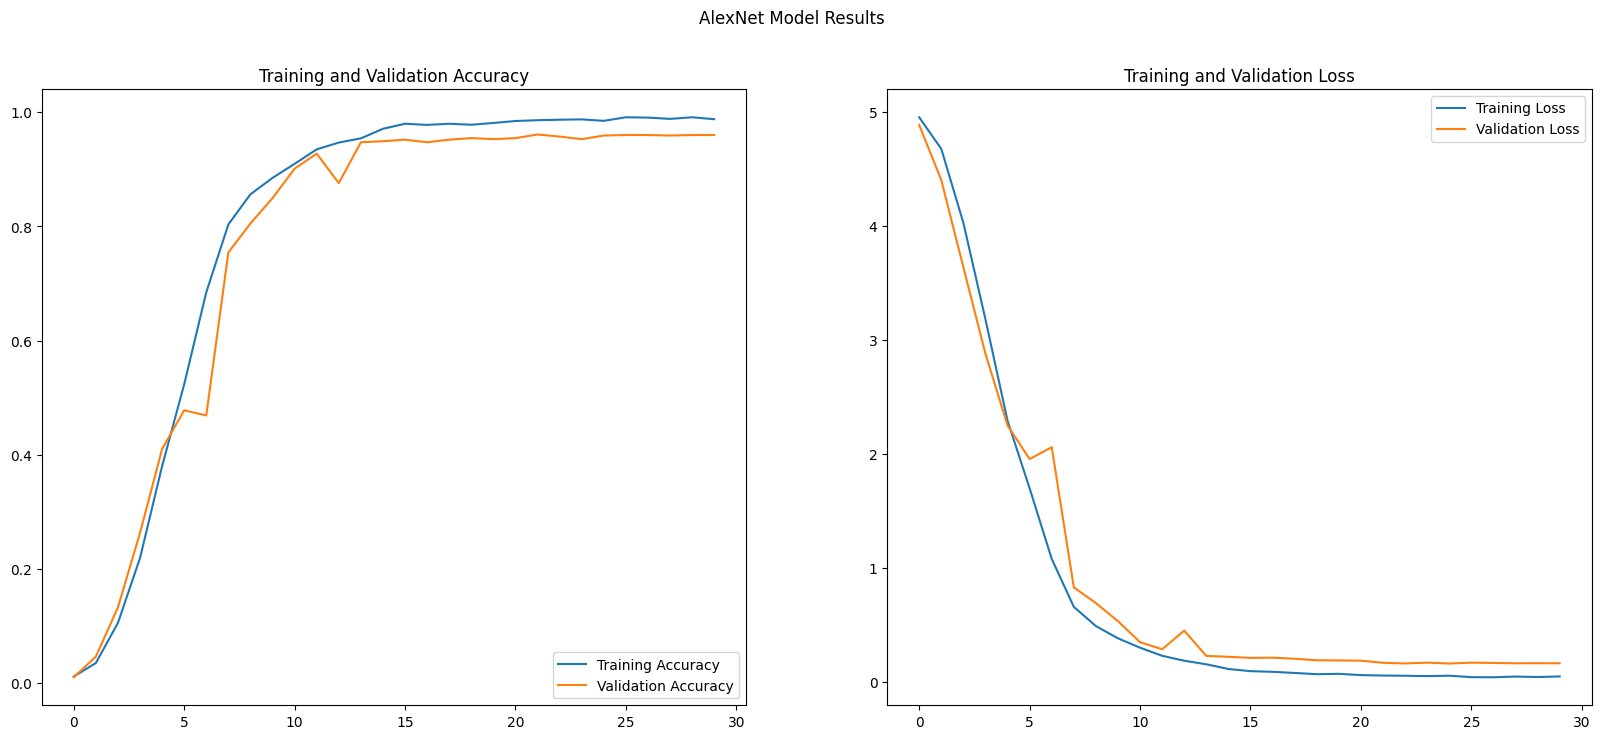

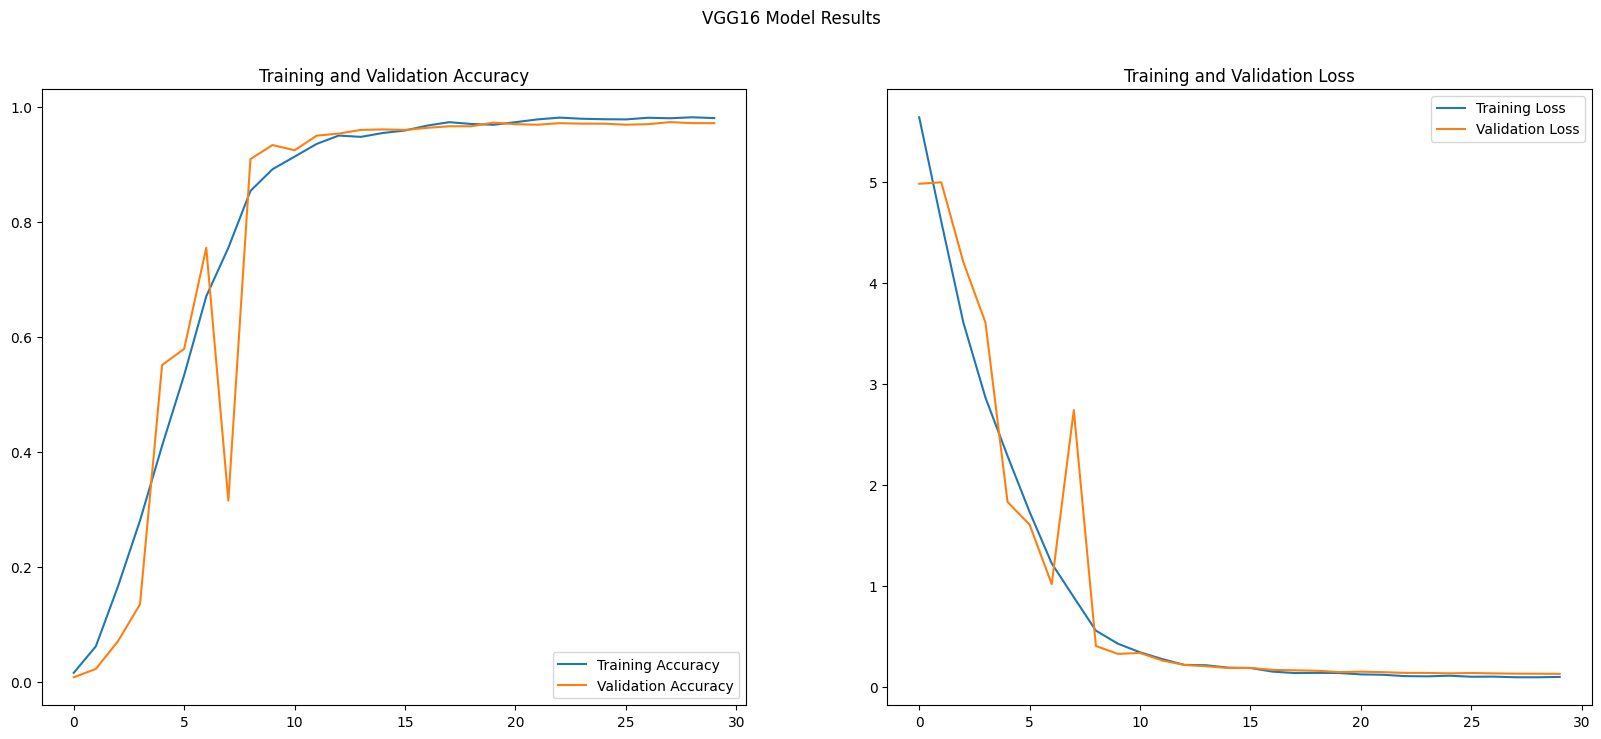

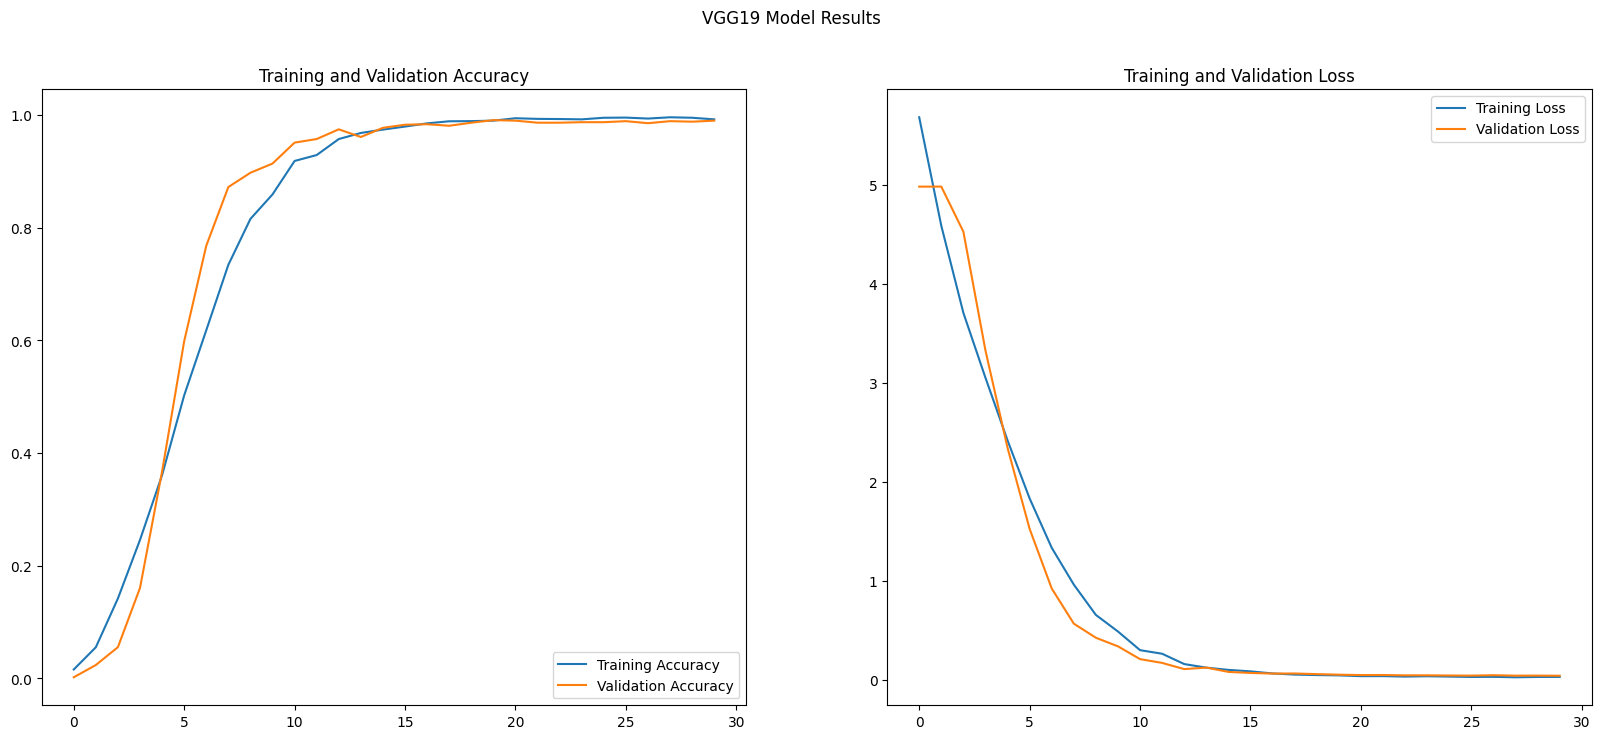

In [13]:
def plot_model_performance(name, history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.suptitle(f'{name} Model Results')
    plt.show()

for name, history in model_histories.items():
    plot_model_performance(name, history)

In [14]:
model_results = {}

for name, model in models.items():
    model_results[name] = model[0].evaluate(test_dataset)

    print(f'\x1b[34m{name} Model Results:\x1b[0m')
    print(f"Test accuracy: {model_results[name][1]*100:.2f}%")
    print(f"Test loss: {model_results[name][0]:.4f}", end = '\n\n')


27/27 [==============================] - 3s 31ms/step - loss: 0.1134 - accuracy: 0.9779
AlexNet Model Results:
Test accuracy: 97.79%
Test loss: 0.1134

27/27 [==============================] - 6s 116ms/step - loss: 0.0960 - accuracy: 0.9826
VGG16 Model Results:
Test accuracy: 98.26%
Test loss: 0.0960

27/27 [==============================] - 4s 64ms/step - loss: 0.0241 - accuracy: 0.9930
VGG19 Model Results:
Test accuracy: 99.30%
Test loss: 0.0241



Saving models and their training histories

In [15]:
for name, model in models.items():
    model[0].save(f'Saved Models/DorsalVein/{name}-{model_results[name][1]*100:.2f}%.keras')
    print(f'Saved {name} Model')


for name, history in model_histories.items():
    del history.history['lr']
    with open(f'Model Histories/DorsalVein/{name}-{model_results[name][1]*100:.2f}%.json', 'w') as json_file:
        json.dump(history.history, json_file)


Saved AlexNet Model
Saved VGG16 Model
Saved VGG19 Model


## Loading trained model

In [16]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm

In [17]:
# Load train and val datasets
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(
    'Datasets/Augmented Dorsal Vein/',
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset='both'
)

class_names = train_dataset.class_names
train_batches = len(train_dataset)

test_size = 0.2

# Calculate sizes for 80-20 split
train_size = int((1 - test_size) * train_batches)
test_size = int(test_size * train_batches)

# Split the dataset
test_dataset = train_dataset.skip(train_batches - test_size)
train_dataset = train_dataset.take(train_size)


def get_dataset_size(dataset):
    num_batches = len(dataset)
    return num_batches * 32

print(f"\nTotal number of samples in train_dataset: {get_dataset_size(train_dataset)} ({len(train_dataset)} batches of 32)")
print(f"Total number of samples in validation_dataset: {get_dataset_size(val_dataset)} ({len(val_dataset)} batches of 32)")
print(f"Total number of samples in test_dataset: {get_dataset_size(test_dataset)} ({len(test_dataset)} batches of 32)")

Found 5516 files belonging to 138 classes.
Using 4413 files for training.
Using 1103 files for validation.

Total number of samples in train_dataset: 3520 (110 batches of 32)
Total number of samples in validation_dataset: 1120 (35 batches of 32)
Total number of samples in test_dataset: 864 (27 batches of 32)


In [18]:
alexnet_model = keras.models.load_model('Saved Models/DorsalVein/AlexNet-97.56%.keras')
vgg16_model = keras.models.load_model('Saved Models/DorsalVein/VGG16-98.84%.keras')
vgg19_model = keras.models.load_model('Saved Models/DorsalVein/VGG19-97.91%.keras')

In [19]:
def decision_level_fusion_paper(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            # Assign weights based on correct or incorrect recognition
            weight_alexnet = 1 if prediction_alexnet == label else 0
            weight_vgg16 = 1 if prediction_vgg16 == label else 0
            weight_vgg19 = 1 if prediction_vgg19 == label else 0

            # Calculate the final decision
            final_decision = weight_alexnet + weight_vgg16 + weight_vgg19 

            # Update accuracy metrics
            correct_predictions += 1 if final_decision >= 2 else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

paper_fusion_accuracy = decision_level_fusion_paper(test_dataset)
print(f"Accuracy: {paper_fusion_accuracy:.2%}")


Evaluating Dataset With Decision Fusion: 100%|██████████| 27/27 [02:34<00:00,  5.72s/batch]

Accuracy: 98.95%


In [20]:
def decision_level_fusion_improved(dataset):
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataset, desc="Evaluating Dataset With Improved Decision Fusion", unit="batch"):
        batch_size = len(labels)

        for i in range(batch_size):
            img = images[i]
            label = labels[i]

            # Pre-process the image
            img_array = keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0)

            # Get individual predictions
            prediction_alexnet = tf.argmax(alexnet_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg16 = tf.argmax(vgg16_model.predict(img_array, verbose=0)[0]).numpy()
            prediction_vgg19 = tf.argmax(vgg19_model.predict(img_array, verbose=0)[0]).numpy()

            predictions_list = [prediction_alexnet, prediction_vgg16, prediction_vgg19]

            joint_decision = max(set(predictions_list), key=predictions_list.count)

            # Update accuracy metrics
            correct_predictions += 1 if joint_decision == label else 0
            total_samples += 1

    # Calculate test accuracy
    test_accuracy = correct_predictions / total_samples
    return test_accuracy

improved_fusion_accuracy = decision_level_fusion_improved(test_dataset)
print(f"Test Accuracy: {improved_fusion_accuracy:.2%}")


Evaluating Dataset With Improved Decision Fusion: 100%|██████████| 27/27 [02:32<00:00,  5.64s/batch]

Test Accuracy: 99.19%


In [21]:
y = [model.evaluate(test_dataset, verbose=0)[1] for model in [alexnet_model, vgg16_model, vgg19_model]]
y.append(paper_fusion_accuracy)
y.append(improved_fusion_accuracy)

Text(0.5, 1.0, 'DorsalVein Results Comparison')

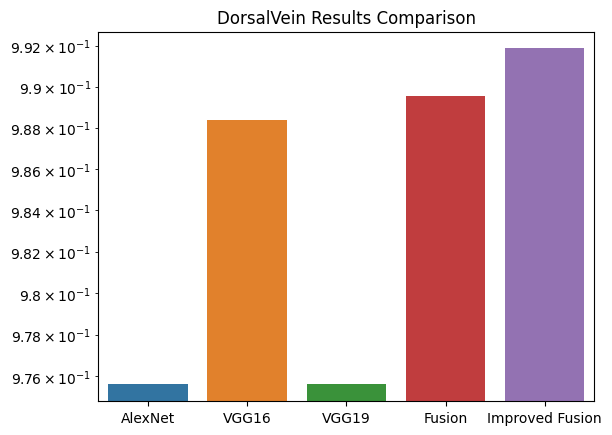

In [22]:
import seaborn as sns

plt.yscale('log')
sns.barplot(y=y, x=['AlexNet', 'VGG16', 'VGG19', 'Fusion', 'Improved Fusion'])
plt.title('DorsalVein Results Comparison')

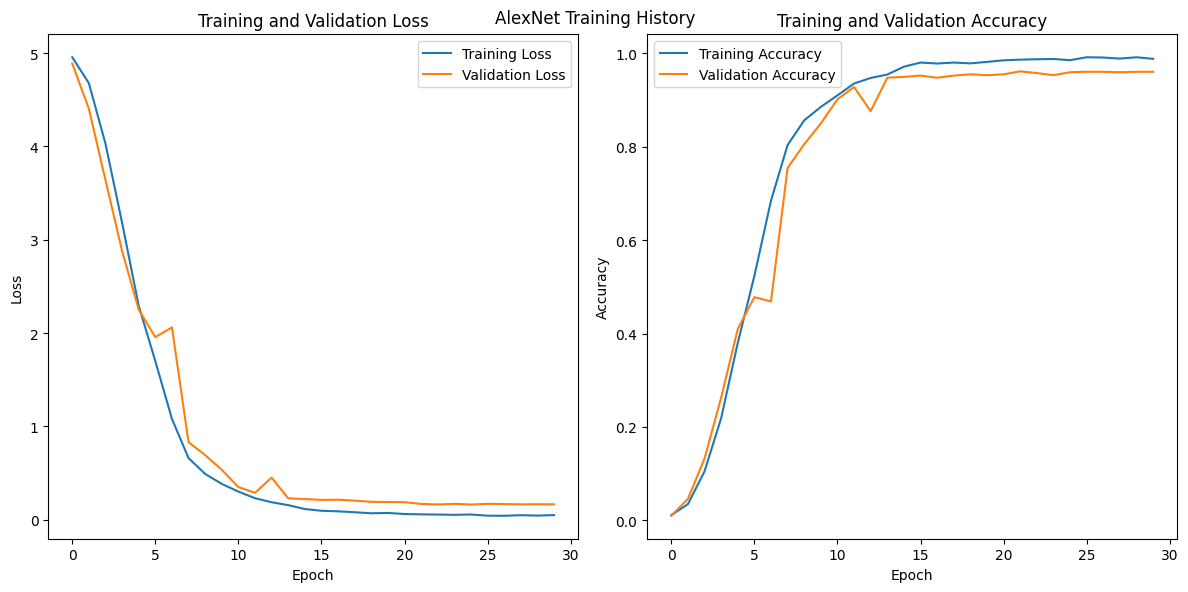

In [26]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/DorsalVein/AlexNet-97.79%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.suptitle('AlexNet Training History')
plt.show()


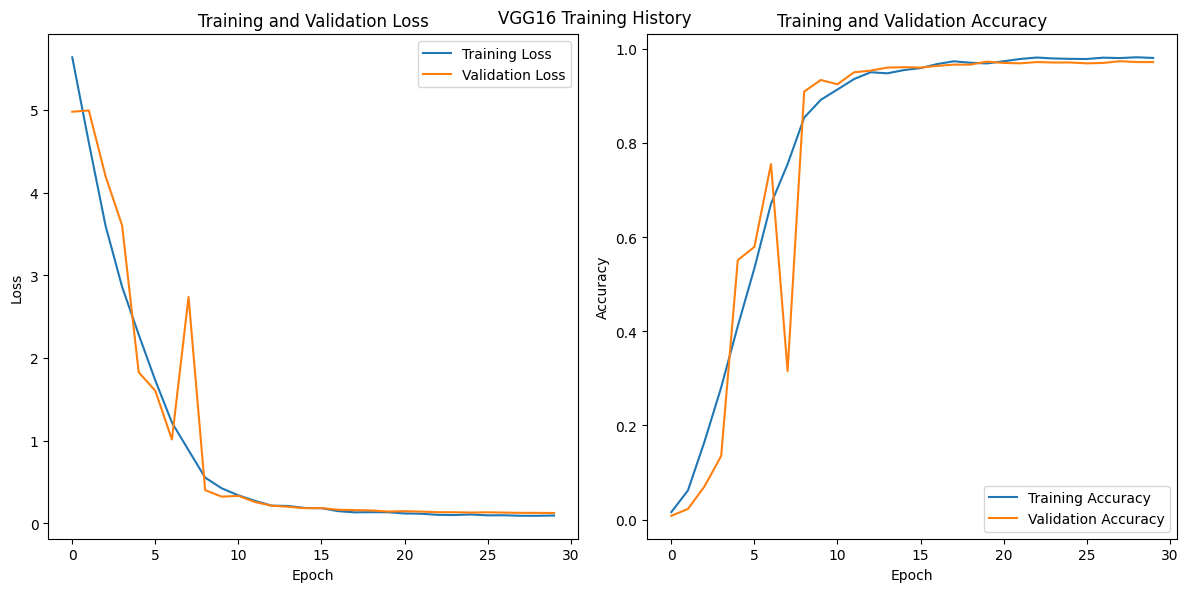

In [27]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/DorsalVein/VGG16-98.26%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.suptitle('VGG16 Training History')
plt.show()


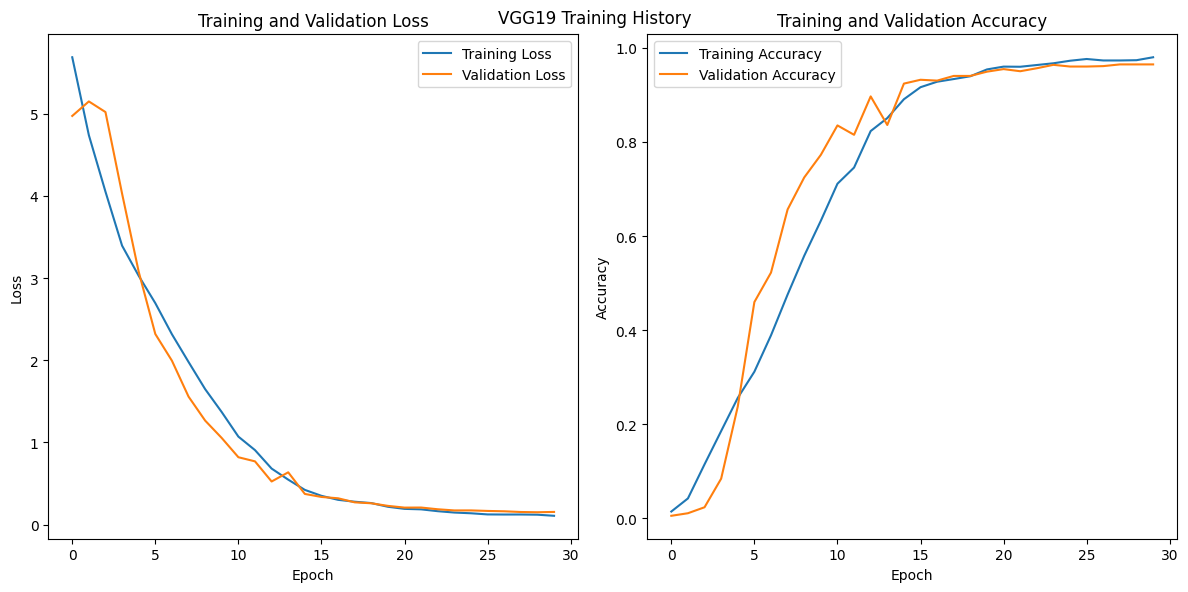

In [28]:
import json
import matplotlib.pyplot as plt

# Load the JSON file
with open('Model Histories/DorsalVein/VGG19-97.91%.json', 'r') as f:
    history = json.load(f)

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.suptitle('VGG19 Training History')
plt.show()
